<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Predicci%C3%B3n_de_da%C3%B1os_por_terremoto_Driven_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predictor de Richter: Modelización de los daños causados por terremotos**

*Jesús Roque Armas Martín - CEIABD*

# Descripción del problema


*   Texto descriptivo

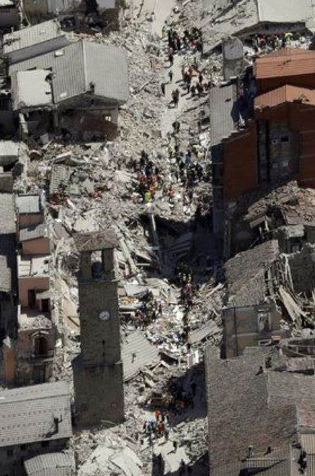

   [Derechos de la imagen](https://www.bing.com/ck/a?!&&p=b097f6d9d9416fdeJmltdHM9MTcxMjM2MTYwMCZpZ3VpZD0zMzY2ZGJhMi1mYThkLTYyMTItMGYwZi1jYjQ5ZmJhNjYzY2MmaW5zaWQ9NTIwMg&ptn=3&ver=2&hsh=3&fclid=3366dba2-fa8d-6212-0f0f-cb49fba663cc&psq=AP+News&u=a1aHR0cHM6Ly9hcG5ld3MuY29tLw&ntb=1)






Importación de las librerías necesarias

In [1]:
!pip install lazypredict

In [2]:
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC # Support Vector Classifier

import lazypredict
from lazypredict.Supervised import LazyClassifier

import sklearn.externals
import joblib

# Importación del dataset

Importo los ficheros CSV, origen de los datos, descargados de driven data a mi repositorio de [GitHub](https://github.com/roquearmas/datasets/).

Posteriormente, uniré los valores de las x con sus etiquetas (y), ya que, en principio, vienen separadas. Luego descargaré ese dataset para inspeccionarlo, ya que parece ser bastante grande.

In [3]:
url_base ='https://github.com/roquearmas/datasets/releases/download/driven_Earthwuake/'

df_submission= pd.read_csv(url_base + 'submission_format.csv?raw=true')
df_train_X= pd.read_csv( url_base + 'train_values.csv?raw=true')
df_train_y= pd.read_csv( url_base + 'train_labels.csv?raw=true')
df_test_X= pd.read_csv ( url_base + 'test_values.csv?raw=true')

df_train_X.head()


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_submission.head()

,building_id,damage_grade
0,300051,1
1,99355,1
2,890251,1
3,745817,1
4,421793,1


In [5]:
df_train_y.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [6]:
df_test_X.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


Uno los dataframes de X e y de train para obtener uno solo

In [7]:
df_train = pd.merge(df_train_X,df_train_y,on=['building_id'])

df_train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


Descargo el dataframe obtenido para inspeccionarlo

In [8]:
with open('datos_train.csv', 'w') as f:
  df_train.to_csv(f,  index = False)

files.download('datos_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Verificar si hay datos nulos en el dataset

In [9]:
df_train.loc[df_train.isnull().any(axis=1)]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade


Se comprueba que no hay un solo dato nulo en el dataset generado.

# Selección de filas

Elijo la zona 20 porque tiene un número suficiente de registros para el estudio y los datos, entre los distintos valores de y, están más balanceados que en ninguna zona geográfica.

In [10]:
df_train_filtrado = df_train[df_train['geo_level_1_id'] == 20]

In [11]:
df_train_filtrado.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
7,475515,20,323,12236,2,0,8,6,t,w,...,0,0,0,0,0,0,0,0,0,1
31,16485,20,953,6651,2,15,13,5,t,w,...,0,0,0,0,0,0,0,0,0,2
46,132583,20,261,11561,2,15,7,5,n,w,...,0,0,0,0,0,0,0,0,0,2
50,871517,20,261,2189,2,10,7,5,t,w,...,0,0,0,0,0,0,0,0,0,2
76,425720,20,136,4769,2,0,5,7,t,w,...,0,0,0,0,0,0,0,0,0,1


# Transformación de datos
Comienzo con la transformación de los tipos de datos de las columnas categóricas, que tienen valores con carácteres aleatorios, en numéricos

In [12]:
# hago copia de los datasets sin transformar
df_train_trans= df_train_filtrado.copy()
df_test_trans = df_test_X.copy()
# conocer los valores categóricos de cada columna
print('land_surface_condition - Valores:', df_train_trans['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_train_trans['foundation_type'].unique())
print('roof_type              - Valores:', df_train_trans['roof_type'].unique())
print('ground_floor_type      - Valores:', df_train_trans['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_train_trans['other_floor_type'].unique())
print('position               - Valores:', df_train_trans['position'].unique())
print('plan_configuration     - Valores:', df_train_trans['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_train_trans['legal_ownership_status'].unique())

land_surface_condition - Valores: ['t' 'n' 'o']
foundation_type        - Valores: ['w' 'r' 'i' 'h' 'u']
roof_type              - Valores: ['q' 'n' 'x']
ground_floor_type      - Valores: ['v' 'f' 'x' 'z' 'm']
other_floor_type       - Valores: ['x' 'q' 'j' 's']
position               - Valores: ['s' 'o' 't' 'j']
plan_configuration     - Valores: ['u' 'd' 'q' 'a' 's' 'n' 'o' 'c' 'f' 'm']
legal_ownership_status - Valores: ['v' 'a' 'r' 'w']


In [13]:
df_train_trans.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
7,475515,20,323,12236,2,0,8,6,t,w,...,0,0,0,0,0,0,0,0,0,1
31,16485,20,953,6651,2,15,13,5,t,w,...,0,0,0,0,0,0,0,0,0,2
46,132583,20,261,11561,2,15,7,5,n,w,...,0,0,0,0,0,0,0,0,0,2
50,871517,20,261,2189,2,10,7,5,t,w,...,0,0,0,0,0,0,0,0,0,2
76,425720,20,136,4769,2,0,5,7,t,w,...,0,0,0,0,0,0,0,0,0,1


Asigno valores numéricos a cada uno de los valores categóricos de cada columna

In [14]:
df_train_trans["land_surface_condition"].replace(['t', 'o', 'n'],[0, 1, 2], inplace=True)
df_train_trans["foundation_type"].replace(['r', 'w', 'i', 'u', 'h'],[0, 1, 2, 3, 4], inplace=True)
df_train_trans["roof_type"].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df_train_trans["ground_floor_type"].replace(['f', 'x', 'v', 'z', 'm',],[0, 1, 2, 3, 4], inplace=True)
df_train_trans["other_floor_type"].replace(['q', 'x', 'j', 's'],[0, 1, 2, 3], inplace=True)
df_train_trans["position"].replace(['t', 's', 'j', 'o'],[0, 1, 2, 3], inplace=True)
df_train_trans["plan_configuration"].replace(['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df_train_trans["legal_ownership_status"].replace(['v', 'a', 'r', 'w'],[0, 1, 2, 3], inplace=True)

También para el dataframe de test

In [15]:
df_test_trans["land_surface_condition"].replace(['t', 'o', 'n'],[0, 1, 2], inplace=True)
df_test_trans["foundation_type"].replace(['r', 'w', 'i', 'u', 'h'],[0, 1, 2, 3, 4], inplace=True)
df_test_trans["roof_type"].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df_test_trans["ground_floor_type"].replace(['f', 'x', 'v', 'z', 'm',],[0, 1, 2, 3, 4], inplace=True)
df_test_trans["other_floor_type"].replace(['q', 'x', 'j', 's'],[0, 1, 2, 3], inplace=True)
df_test_trans["position"].replace(['t', 's', 'j', 'o'],[0, 1, 2, 3], inplace=True)
df_test_trans["plan_configuration"].replace(['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df_test_trans["legal_ownership_status"].replace(['v', 'a', 'r', 'w'],[0, 1, 2, 3], inplace=True)

Comprobación. Nuevos valores de las columnas anteriormente categóricas

In [16]:
print('land_surface_condition - Valores:', df_train_trans['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_train_trans['foundation_type'].unique())
print('roof_type              - Valores:', df_train_trans['roof_type'].unique())
print('ground_floor_type      - Valores:', df_train_trans['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_train_trans['other_floor_type'].unique())
print('position               - Valores:', df_train_trans['position'].unique())
print('plan_configuration     - Valores:', df_train_trans['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_train_trans['legal_ownership_status'].unique())

land_surface_condition - Valores: [0 2 1]
foundation_type        - Valores: [1 0 2 4 3]
roof_type              - Valores: [1 0 2]
ground_floor_type      - Valores: [2 0 1 3 4]
other_floor_type       - Valores: [1 0 2 3]
position               - Valores: [1 3 0 2]
plan_configuration     - Valores: [1 0 3 6 2 7 9 5 8 4]
legal_ownership_status - Valores: [0 1 2 3]


In [17]:
print('land_surface_condition - Valores:', df_test_trans['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_test_trans['foundation_type'].unique())
print('roof_type              - Valores:', df_test_trans['roof_type'].unique())
print('ground_floor_type      - Valores:', df_test_trans['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_test_trans['other_floor_type'].unique())
print('position               - Valores:', df_test_trans['position'].unique())
print('plan_configuration     - Valores:', df_test_trans['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_test_trans['legal_ownership_status'].unique())

land_surface_condition - Valores: [0 2 1]
foundation_type        - Valores: [0 1 3 4 2]
roof_type              - Valores: [0 2 1]
ground_floor_type      - Valores: [0 2 1 4 3]
other_floor_type       - Valores: [0 2 1 3]
position               - Valores: [1 0 2 3]
plan_configuration     - Valores: [0 1 3 6 5 4 2 9 8 7]
legal_ownership_status - Valores: [0 1 3 2]


Coprobamos los tipos de datos, después de las transformaciones

In [18]:
df_train_trans.dtypes

building_id                               int64
geo_level_1_id                            int64
geo_level_2_id                            int64
geo_level_3_id                            int64
count_floors_pre_eq                       int64
age                                       int64
area_percentage                           int64
height_percentage                         int64
land_surface_condition                    int64
foundation_type                           int64
roof_type                                 int64
ground_floor_type                         int64
other_floor_type                          int64
position                                  int64
plan_configuration                        int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick  

**Escalamiento**

Escalo todas las columnas , ya que todas tienen valores numéricos.

In [19]:
Scaler=MinMaxScaler()

datos_escalados=Scaler.fit_transform(df_train_trans)
df_train_escalados=pd.DataFrame(datos_escalados, columns=df_train_trans.columns)

datos_escalados = Scaler.fit_transform(df_test_trans)
df_test_escalados = pd.DataFrame(datos_escalados, columns=df_test_trans.columns)

In [20]:
df_train_escalados.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,0.45,0.00,0.22,0.98,0.20,0.00,0.08,0.17,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.02,0.00,0.68,0.53,0.20,0.02,0.14,0.12,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
2,0.13,0.00,0.18,0.92,0.20,0.02,0.07,0.12,1.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
3,0.83,0.00,0.18,0.17,0.20,0.01,0.07,0.12,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
4,0.40,0.00,0.09,0.38,0.20,0.00,0.05,0.21,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
df_test_escalados.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0.28,0.57,0.42,0.90,0.29,0.02,0.07,0.13,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.09,0.20,0.10,0.95,0.14,0.03,0.13,0.10,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.85,0.73,0.01,0.80,0.14,0.01,0.03,0.10,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.71,0.87,0.03,0.05,0.00,0.00,0.20,0.03,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.40,0.57,0.20,0.63,0.29,0.02,0.08,0.17,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


***Separar datos de train y validación***

Elijo un 80% para train y un 20% para validación. Hay que separar los datos de manera estratificada, para que haya datos de todas las etiquetas en los dos conjuntos de datos

In [22]:
df_train_ult, df_valid_ult = train_test_split(df_train_escalados, test_size=0.2, stratify=df_train_escalados['damage_grade'], random_state=42)

Obtengo la distribución de datos en cada una de las clases, para los entornos de entrenamiento y validación, respectivamente.

In [23]:
print('Datos de train, distribución de las clases')
print('------------------------------------------')
print(df_train_ult['damage_grade'].value_counts())
print('------------------------------------------')
print('Porcentajes')
print('------------------------------------------')
porcentajes=(df_train_ult['damage_grade'].value_counts()/len(df_train_ult))*100
porcentaje_form= porcentajes.apply(lambda x: "{:.2f}%".format(x))
print (porcentaje_form)

Datos de train, distribución de las clases
------------------------------------------
damage_grade
0.50    9487
0.00    2649
1.00    1636
Name: count, dtype: int64
------------------------------------------
Porcentajes
------------------------------------------
damage_grade
0.50    68.89%
0.00    19.23%
1.00    11.88%
Name: count, dtype: object


In [24]:
print('Datos de validation, distribución de las clases')
print('-----------------------------------------------')
print(df_valid_ult['damage_grade'].value_counts())

porcentajes=(df_valid_ult['damage_grade'].value_counts()/len(df_valid_ult))*100
porcentaje_form= porcentajes.apply(lambda x: "{:.2f}%".format(x))
print('------------------------------------------')
print('Porcentajes')
print('------------------------------------------')
print (porcentaje_form)

Datos de validation, distribución de las clases
-----------------------------------------------
damage_grade
0.50    2373
0.00     662
1.00     409
Name: count, dtype: int64
------------------------------------------
Porcentajes
------------------------------------------
damage_grade
0.50    68.90%
0.00    19.22%
1.00    11.88%
Name: count, dtype: object


*Se observa que los porcentajes son casi idéndticos para los dos conjuntos de datos*

# Reducción de características

Las dos primeras columnas no deberían formar parte de los cálculos, puesto que el id del edificio no es relevante y el área geográfica siempre va a ser la misma en nuestro dataset.

In [25]:
df_estudio_train = df_train_ult.iloc[:,2:]
df_estudio_val   = df_valid_ult.iloc[:,2:]
df_estudio_test  = df_test_escalados.iloc[:,2:]



***Dendograma***

Distancia Media	  38.34


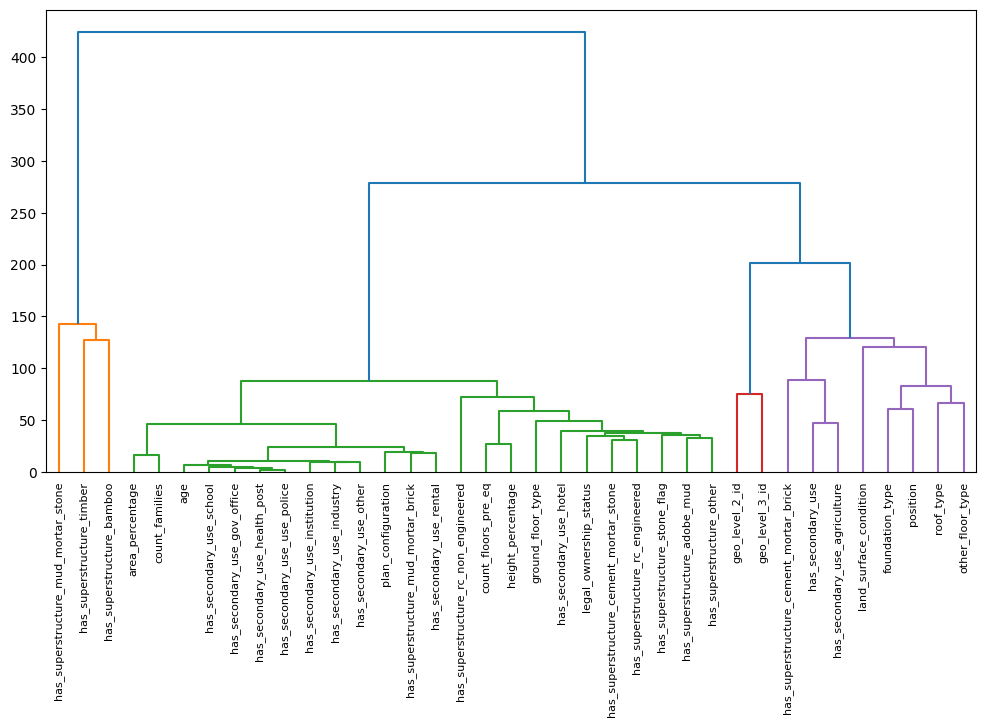

In [26]:
import numpy as np
import sklearn.neighbors
import matplotlib.pyplot as plt

## Clustering jerárquico
# 1. Obtener la matriz de distancia entre todos los elementos

dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(df_estudio_train.drop('damage_grade', axis=1).T)
#D=dist.pairwise(X_train.T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Construimos el dendograma
from scipy import cluster
plt.figure(figsize=(12, 6))
# Seleccionamos como distancia intercluster el vecino más alejado (complete)
clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=160,labels=df_estudio_train.drop('damage_grade', axis=1).columns.to_list(),leaf_rotation=90)
#cluster.hierarchy.dendrogram(clusters, color_threshold=160,labels=X_train.columns.to_list(),leaf_rotation=90)
plt.show()

Obtenemos el grupo/cluster al que pertenece cada observación/muestra/fila del dataset

In [27]:
threshold = 160 # ad-hoc, es decir por criterio de la persona que está resolviendo el problema
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')

# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 4


array([3, 3, 2, 2, 2, 2, 4, 4, 4, 2, 4, 4, 2, 2, 1, 2, 2, 2, 4, 1, 1, 2,
       2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Se nos agrupan las columnas en 4 clusters
Ahora puedo aplicar PCA

In [28]:
from sklearn.decomposition import PCA
import numpy as np

# Reducimos la dimensionalidad de los datos (a dos dimensiones)
pca = PCA(n_components = 2)
X_pca = df_estudio_train.drop('damage_grade', axis=1)
y_pca = df_estudio_train['damage_grade'].astype('int')
X_pca = pca.fit_transform(X_pca)
X_pca

array([[ 0.32366384,  0.24827683],
       [-0.8872675 ,  0.21934171],
       [ 0.41623964,  1.78394716],
       ...,
       [-0.0517236 , -0.87700961],
       [ 0.23483819, -0.58894388],
       [-0.06566938, -0.86172326]])

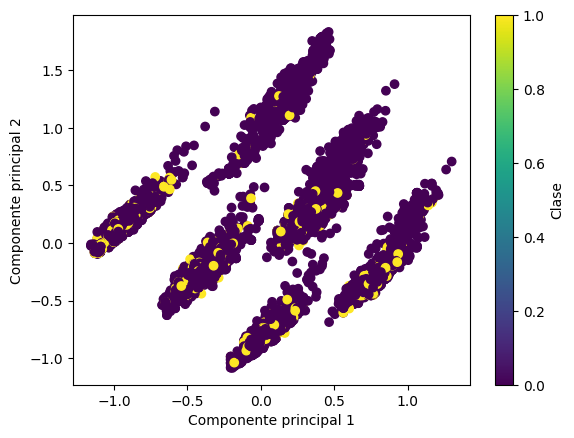

In [29]:
# Visualizar los datos en el nuevo espacio de características PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap='viridis')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Clase')
plt.show()


**Matriz decorrelación**

<Axes: >

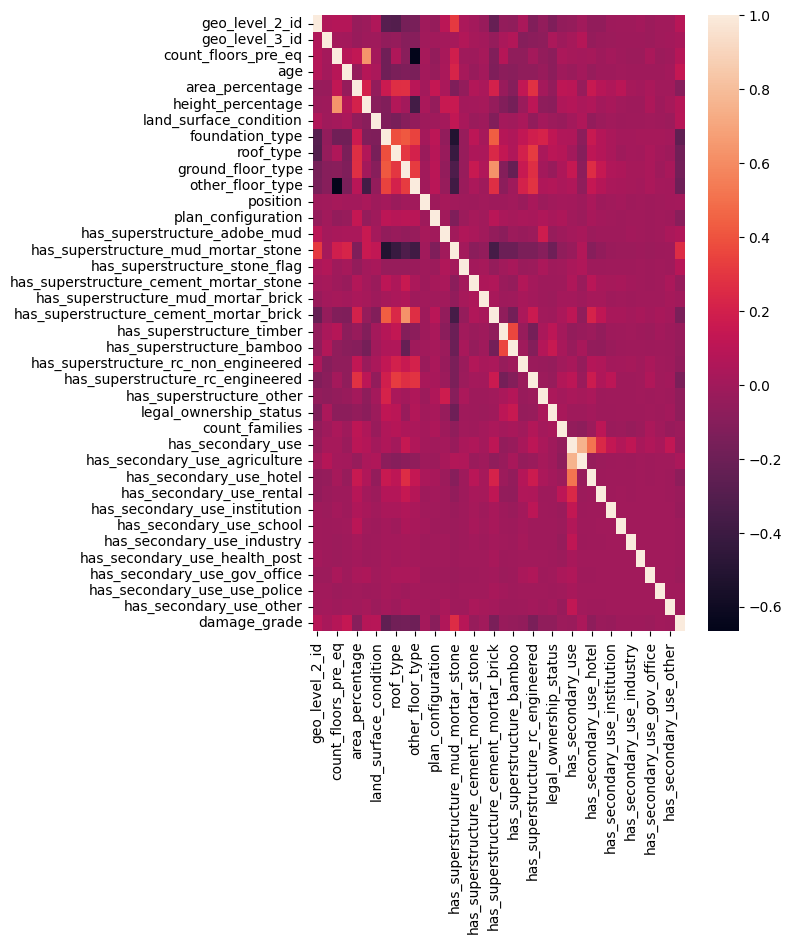

In [30]:
plt.rcParams["figure.figsize"] = (6,8)
sns.heatmap(df_estudio_train.corr())

Expresada en una sola columna

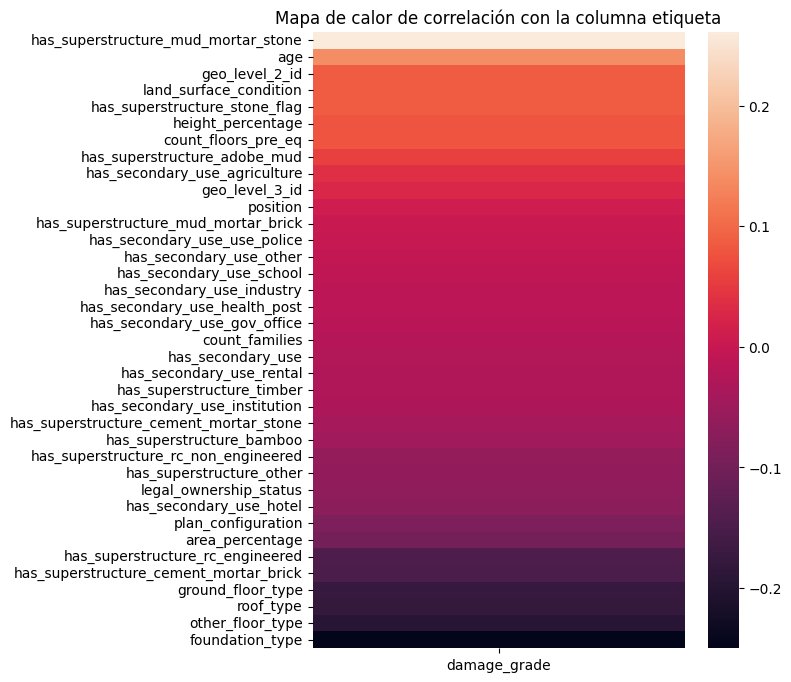

In [31]:
DEPOSIT_COLUMN = 'damage_grade'
correlation_matrix = df_estudio_train.corr()
def plot_deposit_correlations(data):
    # Aísla la columna de deposito y visualiza todas las demás en función de ella
    deposit_correlation_column = pd.DataFrame(correlation_matrix[DEPOSIT_COLUMN].drop(DEPOSIT_COLUMN))
    deposit_correlation_column = deposit_correlation_column.sort_values(by=DEPOSIT_COLUMN, ascending=False)
    sns.heatmap(deposit_correlation_column)
    plt.title('Mapa de calor de correlación con la columna etiqueta')

plot_deposit_correlations(df_estudio_train)

In [32]:
columnas_irrelevantes      = ['damage_grade','has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post']
columnas_irrelevantes_test = ['has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post']
X_train = df_estudio_train.drop(columnas_irrelevantes, axis=1)
y_train = df_estudio_train['damage_grade'].replace({0.0:1,0.5 :2, 1.0:3})
X_val   = df_estudio_val.drop(columnas_irrelevantes, axis=1)
y_val   = df_estudio_val['damage_grade'].replace({0.0:1,0.5 :2, 1.0:3})
X_test  = df_estudio_test.drop(columnas_irrelevantes_test, axis=1)
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train , y_train)

LogisticRegression(max_iter=10000)

Muestro los coeficientes de regresión obtenidos

In [33]:
print(model_lr.coef_)

[[ 2.04018856e-01  2.38599132e-02  1.27657192e+00 -4.64852493e+00
   5.95708793e-01 -1.36550496e+00 -3.28770809e-01  7.89945101e-01
   1.09197802e-01  4.11913885e-01  6.07102851e-01 -2.01440943e-01
   8.99862511e-01 -3.80230963e-01 -6.22196729e-01 -1.39754000e+00
   6.91078161e-02 -3.71129161e-01  6.59378874e-02 -7.80483779e-02
   9.24872982e-02 -3.56417723e-02  7.93034281e-01  3.90184591e-01
   2.61073753e-01 -5.45164947e-01  3.05079477e-01 -5.12666716e-01
  -1.09882627e-01 -3.20285243e-02  4.04431386e-01  2.29279713e-02
   3.51742704e-02 -1.45019358e-01]
 [-3.39121592e-02 -1.44172390e-03 -3.75586005e-01  2.98095406e+00
   5.88125466e-01  1.04699444e-01  1.73847494e-01 -5.48805592e-02
   1.51341086e-01 -1.34386324e-01 -3.49970987e-01 -1.32137417e-01
  -2.91499710e-01 -8.49359038e-02  2.12914750e-01  3.81156000e-01
  -2.64581597e-03 -2.97840853e-02  5.34632416e-01  1.61825804e-01
   1.84553638e-03 -3.19906345e-02 -2.52104568e-01 -6.83454609e-01
  -2.15584525e-01  1.49038709e+00  3.3716

Ordenar los coeficientes por relevancia, de menos a más

In [34]:
orden = np.argsort(np.abs(model_lr.coef_))
orden_array = np.array(orden)
print(X_train.columns.take(orden))


Index(['has_secondary_use_school', 'geo_level_3_id',
       'has_secondary_use_rental', 'has_secondary_use_industry',
       'has_superstructure_rc_non_engineered',
       'has_superstructure_cement_mortar_brick',
       'has_superstructure_cement_mortar_stone', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'roof_type', 'has_secondary_use_hotel',
       'has_secondary_use_other', 'position', 'geo_level_2_id',
       'legal_ownership_status', 'has_secondary_use', 'land_surface_condition',
       'has_superstructure_mud_mortar_brick', 'has_superstructure_adobe_mud',
       'has_superstructure_other', 'has_secondary_use_institution',
       'ground_floor_type', 'has_secondary_use_agriculture', 'count_families',
       'area_percentage', 'other_floor_type',
       'has_superstructure_mud_mortar_stone', 'foundation_type',
       'has_superstructure_rc_engineered', 'plan_configuration',
       'count_floors_pre_eq', 'height_percentage',
       'has_superstructure_stone_fla

Evalúo los resultados mediante el mismo coeficiente que utiliza driven data, micro averaged F1 score

In [35]:
preds_train = model_lr.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_train, average='micro'))


F1_score del modelo en validation: 0.70267131242741


Pruebo el modelo con test para subir el primer fichero

In [ ]:
y_pred_lr = model_lr.predict(X_test)
np.unique(y_pred_lr)

In [39]:
def subir_fichero (y_pred, nombre_fichero):
  submit_lr = df_submission.copy()
  resultado = np.rint( y_pred_lr )
  resultado = resultado.astype(int)
  submit_lr['damage_grade'] = resultado
  submit_lr.to_csv(nombre_fichero,index=False)
  files.download(nombre_fichero)

In [ ]:
subir_fichero (y_pred_lr,'preds_lr.csv')


**Linear Regression Con Cross Validation**

In [ ]:
X_train_cv= X_train.copy() #al poner shuffle =True desordenaba el dataset, hago copia para que no lo desordene
y_train_cv= y_train.copy()
cv = KFold(n_splits = 20, shuffle = True) #al poner shuffle =True desordenaba el dataset
cv_f1scores=[]
for i in range(21,50):
  for cv_train, cv_test in cv.split(X_train):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_cv.iloc[cv_train]
    cv_train_y = y_train_cv.iloc[cv_train]

    # vamos entrenando los modelos
    model_lr.fit(cv_train_x, cv_train_y)

    #guardo el predict de cada modelo
    y_pred = model_lr.predict(X_train.iloc[cv_test])
    #y_np=np.zeros(len(cv_test))
    y_np=y_train.iloc[cv_test].values

    cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

    cv_f1scores.append(cv_f1score)
  #guardo la media de los f1_Scores, para cada split
  media_scores=sum(cv_f1scores)/len(cv_f1scores)

  #recorro los clasificadores y voy mostrando la precision por cada uno de ellos
  print ("F1_Score medio: = %.4f para %i splits" %  (media_scores,i ))

In [ ]:
X_train_cv= X_train.copy() #al poner shuffle =True desordenaba el dataset, hago copia para que no lo desordene
y_train_cv= y_train.copy()
cv = KFold(n_splits = 8, shuffle = True) #al poner shuffle =True desordenaba el dataset
cv_f1scores=[]

for cv_train, cv_test in cv.split(X_train):
  # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
  cv_train_x = X_train_cv.iloc[cv_train]
  cv_train_y = y_train_cv.iloc[cv_train]

  # vamos entrenando los modelos
  model_lr.fit(cv_train_x, cv_train_y)

  #guardo el predict de cada modelo
  y_pred = model_lr.predict(X_train.iloc[cv_test])
  #y_np=np.zeros(len(cv_test))
  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)
#guardo la media de los f1_Scores, para cada split
media_scores=sum(cv_f1scores)/len(cv_f1scores)

#recorro los clasificadores y voy mostrando la precision por cada uno de ellos
print ("F1_Score medio: = %.4f" %  (media_scores ))

Hago la predicción del modelo entrenadoc con cross validation,sobre test

In [ ]:
y_pred_lr = model_lr.predict(X_test)


In [ ]:
subir_fichero(y_pred,'lr_cv_RAM.csv')

Estimación de los mejores hiperparámetros con GridSearch

In [ ]:
# Definir rango de parámetros

parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_lr = GridSearchCV(model_lr, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_lr.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = GS_lr.best_params_
print(mejores_params)

In [ ]:
model_lr_gs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_gs.fit(X_train , y_train)

Predicciones del modelo entrenado con las recomendaciones de Grid Search

In [40]:
preds_val = model_lr_gs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

NameError: name 'model_lr_gs' is not defined

In [ ]:
y_pred= model_lr_gs.predict(X_test)


In [ ]:
subir_fichero(y_pred,'lr_GS_RAM.csv')

Aplicacion de Random Search a Logistic Regression

In [ ]:
# Definir rand de parámetros
parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
RS_lr = RandomizedSearchCV(model_lr, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_lr.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = RS_lr.best_params_
print(mejores_params)

In [ ]:
model_lr_rs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_rs.fit(X_train , y_train)
preds_val = model_lr_rs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

In [ ]:
y_pred= model_lr_rs.predict(df_test)
subir_fichero(y_pred,'lr_RS_RAM.csv')

# Reducción de características

Algunas columnas, según el dendograma, pueden agruparse para simplificar el dataset.
Voy a generar la media de los cuatro grupos que arroja el dendograma, por separado, obteniendo datasets con cuatro columnas, más la columna etiqueta

In [36]:
X_train.columns

Index(['geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_othe

In [37]:
columnas_grupo1=['area_percentage','count_families','age','has_secondary_use_school','has_secondary_use_institution','has_secondary_use_industry','has_secondary_use_other','plan_configuration',
                 'has_superstructure_mud_mortar_brick','has_secondary_use_rental','count_floors_pre_eq','height_percentage','has_superstructure_rc_non_engineered','ground_floor_type','has_secondary_use_hotel',
                 'legal_ownership_status','has_superstructure_cement_mortar_stone','has_superstructure_rc_engineered','has_superstructure_stone_flag','has_superstructure_adobe_mud','has_superstructure_other']
columnas_grupo2=['has_superstructure_cement_mortar_brick','has_secondary_use','has_secondary_use_agriculture','land_surface_condition','foundation_type','position','roof_type','other_floor_type']
columnas_grupo3=['geo_level_2_id','geo_level_3_id']
columnas_grupo4=['has_superstructure_mud_mortar_stone','has_superstructure_timber','has_superstructure_bamboo']

media_train1=X_train[columnas_grupo1].mean(axis=1)
media_train2=X_train[columnas_grupo2].mean(axis=1)
media_train3=X_train[columnas_grupo3].mean(axis=1)
media_train4=X_train[columnas_grupo4].mean(axis=1)

media_val1=X_val[columnas_grupo1].mean(axis=1)
media_val2=X_val[columnas_grupo2].mean(axis=1)
media_val3=X_val[columnas_grupo3].mean(axis=1)
media_val4=X_val[columnas_grupo4].mean(axis=1)

media_test1=X_test[columnas_grupo1].mean(axis=1)
media_test2=X_test[columnas_grupo2].mean(axis=1)
media_test3=X_test[columnas_grupo3].mean(axis=1)
media_test4=X_test[columnas_grupo4].mean(axis=1)

X_red_train = pd.DataFrame({'grupo1':media_train1,'grupo2': media_train2,'grupo3': media_train3,'grupo4': media_train4}) # X reducida para train
X_red_val   = pd.DataFrame({'grupo1':media_val1,  'grupo2': media_val2,  'grupo3': media_val3,  'grupo4': media_val4})   # X reducida para validation
X_red_test  = pd.DataFrame({'grupo1':media_test1, 'grupo2': media_test2, 'grupo3': media_test3, 'grupo4': media_test4})  # X reducida para test

In [67]:
X_red_train.head()

,grupo1,grupo2,grupo3,grupo4
8967,0.03,0.18,0.70,0.33
7260,0.03,0.10,0.45,0.33
3067,0.14,0.60,0.08,0.00
6660,0.02,0.26,0.15,0.33
10089,0.03,0.04,0.32,0.33


# SVM - Máquina de Vector de Soporte

In [44]:
model_svc = SVC(kernel='linear', C=1E10)
model_svc.fit(X_red_train, y_train)

Método para evaluar el modelo

In [42]:
def evaluar_modelo (modelo):
  preds_val  = model_svc.predict(X_red_val)
  preds_test = model_svc.predict(X_red_test)

  print(classification_report(preds_val, y_val))
  print('Accuracy en validation:', metrics.accuracy_score(preds_val, y_val))
  print('F1_score en validation:', metrics.f1_score( y_val,preds_val, average='micro'))
  return preds_test

In [77]:
y_test = evaluar_modelo (model_svc)

              precision    recall  f1-score   support

         1.0       0.10      0.52      0.16       122
         2.0       0.98      0.70      0.81      3315
         3.0       0.01      0.43      0.01         7

    accuracy                           0.69      3444
   macro avg       0.36      0.55      0.33      3444
weighted avg       0.94      0.69      0.79      3444

Accuracy en validation: 0.6910569105691057
F1_score en validation: 0.6910569105691057


In [78]:
subir_fichero(y_test,'SVC_RAM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVC con Cross Validation

In [ ]:
cv = KFold(n_splits = 8, shuffle = False) #al poner shuffle =True desordenaba el dataset
cv_f1scores=[]
for cv_train, cv_test in cv.split(X_red_train):
  # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
  cv_train_x = X_train.iloc[cv_train]
  cv_train_y = y_train.iloc[cv_train]

  # vamos entrenando los modelos
  model_svc.fit(cv_train_x, cv_train_y)

  #guardo el predict de cada modelo
  y_pred = model_svc.predict(X_train.iloc[cv_test])
  #y_np=np.zeros(len(cv_test))
  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)
#guardo la media de los f1_Scores, para cada split
media_scores=sum(cv_f1scores)/len(cv_f1scores)

#recorro los clasificadores y voy mostrando la precision por cada uno de ellos
print ("F1_Score medio: = %.4f para %i splits" %  (media_scores,i ))

SVM con GridSearch

In [ ]:
parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_svc = GridSearchCV(model_svc, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_svc.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = GS_svc.best_params_
print(mejores_params)

In [ ]:
model_lr_gs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_gs.fit(X_train , y_train)

# Lazy Predict

In [38]:
lazy_model = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_model.fit(X_red_train, X_red_val, y_train, y_val)

print(models)

 90%|████████▉ | 26/29 [00:41<00:07,  2.57s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 4
[LightGBM] [Info] Start training from score -1.648455
[LightGBM] [Info] Start training from score -0.372715
[LightGBM] [Info] Start training from score -2.130383


100%|██████████| 29/29 [00:42<00:00,  1.46s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
ExtraTreesClassifier               0.67               0.47    None      0.66   
DecisionTreeClassifier             0.62               0.47    None      0.62   
RandomForestClassifier             0.69               0.47    None      0.66   
BaggingClassifier                  0.67               0.47    None      0.65   
ExtraTreeClassifier                0.60               0.44    None      0.61   
LGBMClassifier                     0.72               0.44    None      0.66   
KNeighborsClassifier               0.67               0.44    None      0.64   
NearestCentroid                    0.30               0.41    None      0.32   
LabelPropagation                   0.70               0.40    None      0.63   
LabelSpreading                     0.70               0.40    None      0.63   
GaussianNB                         0.68 

# LGBMClassifier

In [39]:
import lightgbm as lgb

# Crear y entrenar el modelo LGBMClassifier
model = lgb.LGBMClassifier()
model.fit(X_red_train, y_train)

# Hacer predicciones
predictions = model.predict(X_red_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 4
[LightGBM] [Info] Start training from score -1.648455
[LightGBM] [Info] Start training from score -0.372715
[LightGBM] [Info] Start training from score -2.130383
